
# Reproduction of Deep learning improves prediction of drug–drug and drug–food interactions<sup>[1]</sup>
---
Team: **Ahmad Sadeed** (asadeed2), **Andrew Vamos** (avamos2), **Jonathon Green** (jg70)
Video: https://www.youtube.com/watch?v=rysiKnBnmdY
Date: May 7, 2024


Overview: This Jupyter notebook contains a demonstration of how the model for the original paper by Ryu et al<sup>[1]</sup> can be trained successfully using the ChemicalX DDI Python package<sup>[2]</sup>. Here, we demonstrate successful training of a small sized model, then load in fully trained models (via gdown) which were trained locally and plot their performance. The colab link here contains the previous draft for our submission within in a runnable colab notebook: https://colab.research.google.com/drive/1czVPpoFmBesy3y0TGJ8OGixW-emzf3Cq?authuser=1

## Install Packages

In [43]:
import os
from IPython.display import display, Javascript

prebuilt = True
arch_x86_64 = True

if prebuilt and arch_x86_64:

  def show_alert(message):
      js_code = f"alert('{message}');"
      display(Javascript(js_code))

  # Packages needed for the prebuilt wheels
  !pip install wheel

  # PyTDC-0.4.1-py3-none-any.whl # This package prompts the user to restart the session after it's installed
  show_alert("Please do not restart this session when prompted.")
  !wget -O PyTDC-0.4.1-py3-none-any.whl https://drive.usercontent.google.com/download?id=1JbHuCkbLIp9BTbNlj3MB75WfTbz_HUkN&export=download&authuser=0
  !pip install PyTDC-0.4.1-py3-none-any.whl

  # torch_cluster-1.6.3-cp310-cp310-linux_x86_64.whl
  !wget -O torch_cluster-1.6.3-cp310-cp310-linux_x86_64.whl https://drive.usercontent.google.com/download?id=18p4c1tfkp_-xX7OMbDrhFDYK3viefOsY&export=download&authuser=0
  !pip install torch_cluster-1.6.3-cp310-cp310-linux_x86_64.whl

  # torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl
  !wget -O torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl https://drive.usercontent.google.com/download?id=1wi-QdBqogm2K0UG-V-oZLImJw9kSWQaL&export=download&authuser=0
  !pip install torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl

  # chemicalx-0.1.0-py3-none-any.whl
  !wget -O chemicalx-0.1.0-py3-none-any.whl https://drive.usercontent.google.com/download?id=1ZuzW7nq1QPHkXZH9keyvWmxm1eHpYqyq&export=download&authuser=0
  !pip install chemicalx-0.1.0-py3-none-any.whl

else:
  !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
  !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.2+cu121.html
  !pip install torch-cluster -f https://data.pyg.org/whl/torch-2.2.2+cu121.html

  # The official package requires 3.8, we're using a fork that's 3.10 compatiable
  !pip install git+https://github.com/lucag2/chemicalx#egg=chemicalx # ref [3]

# other packages
!pip install torchinfo plotly torchsummary ipykernel gdown
!pip install --upgrade nbformat

<IPython.core.display.Javascript object>

'wget' is not recognized as an internal or external command,
operable program or batch file.
'export' is not recognized as an internal or external command,
operable program or batch file.
'authuser' is not recognized as an internal or external command,
operable program or batch file.


Processing c:\users\andre\documents\uiuc_mcs\2024_spring_cs598dl4h\project\final_repo\final-project-deepddi\pytdc-0.4.1-py3-none-any.whl


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\Andre\\Documents\\UIUC_MCS\\2024_Spring_CS598DL4H\\Project\\final_repo\\final-project-deepddi\\PyTDC-0.4.1-py3-none-any.whl'

'wget' is not recognized as an internal or external command,
operable program or batch file.
'export' is not recognized as an internal or external command,
operable program or batch file.
'authuser' is not recognized as an internal or external command,
operable program or batch file.
ERROR: torch_cluster-1.6.3-cp310-cp310-linux_x86_64.whl is not a supported wheel on this platform.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'export' is not recognized as an internal or external command,
operable program or batch file.
'authuser' is not recognized as an internal or external command,
operable program or batch file.
ERROR: torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl is not a supported wheel on this platform.
'wge

Processing c:\users\andre\documents\uiuc_mcs\2024_spring_cs598dl4h\project\final_repo\final-project-deepddi\chemicalx-0.1.0-py3-none-any.whl


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\Andre\\Documents\\UIUC_MCS\\2024_Spring_CS598DL4H\\Project\\final_repo\\final-project-deepddi\\chemicalx-0.1.0-py3-none-any.whl'



# Introduction

Drug-drug interactions (DDIs) and drug-food interactions (DFIs) significantly impact patient safety and treatment efficacy, presenting complex challenges in pharmacology. Predicting these interactions is crucial but difficult due to the extensive data requirements and often poorly understood mechanisms involved.

The paper by Jae Yong Ryu, Hyun Uk Kim, and Sang Yup Lee<sup>[1]</sup> introduces DeepDDI, a computational framework that uses deep learning to predict DDIs and DFIs from basic drug names and structural information. This method significantly advances the state of the art by not only predicting the occurrence of drug interactions but also describing their potential pharmacological effects in human-readable terms, achieving a mean accuracy of 92.4% across 86 DDI types with the DrugBank<sup>[4]</sup> dataset.

DeepDDI's innovative approach enhances understanding of drug interactions, supports informed clinical decisions, and offers potential mitigation strategies for adverse effects, marking a substantial contribution to the field.Development of models such as DeepDDI should lead to improved safety around drug administration, particularly as new drugs are introduced to the medical community.

Our project aims to replicate the findings of Ryu et al<sup>[1]</sup>. to assess the reproducibility of DeepDDI in a standard computational environment like Google Colab, highlighting its practical implications for improving drug safety and therapeutic strategies.


# Scope of Reproducibility:

Our project seeks to validate critical aspects of the DeepDDI model proposed by Ryu et al<sup>[1]</sup>. to assess its practicality, accuracy, and usability in predicting drug-drug and drug-food interactions using a standard computational environment. The following hypotheses from the original paper will be tested with corresponding experiments:

**Hypothesis**: DeepDDI can predict drug-drug interactions with high accuracy using only drug names and structural information as inputs.

* Experiment: We will replicate the model using the same dataset from DrugBank<sup>[4]</sup> used in the original study. Our experiment will involve retraining the DeepDDI model within our environment (Google Colab) and comparing the prediction accuracy with the reported mean accuracy of 92.4%. This test will confirm if DeepDDI maintains its efficacy across different computational setups.



# Methodology

This section is organized into five primary subsections: Environment, Data, Model, Training, and Evaluation. Together, these describe the comprehensive framework of our experimental setup, ensuring a clear understanding of each component involved in the study.

-   **Environment**: This subsection outlines the technical setup and computational resources used to conduct the experiments. It includes details about the software environment, including Python versions, necessary libraries, and frameworks like ChemicalX.

-   **Data**: This subsection details the source, structure, and processing of the data used in our experiments. It describes how the data was acquired, any preprocessing steps taken, and the final format used for modeling. This ensures transparency and reproducibility in how data is handled and prepared for modeling.

-   **Model**: This subsection describes the architecture of the neural networks used, including layers, nodes, and activation functions. It details the rationale behind the choice of architecture and how it is suited to address the problem at hand. The section also includes the specific configurations tested, the training process, and the techniques used for model validation.

-   **Training**: This subsection explains the procedures followed during the model training phase. It includes details on the training algorithms, batch sizes, number of epochs, and learning rates. Adjustments made to the model during the training process, such as tuning hyperparameters and applying regularization techniques like dropout or batch normalization, are also described.

-   **Evaluation**: This subsection details how the models were evaluated. It describes the metrics used to assess model performance, such as accuracy, precision, recall, and F1 score. It also explains the validation techniques employed, including cross-validation or the use of a hold-out validation set, to ensure that the evaluation is robust and the model generalizes well to unseen data.

Each part is accompanied by annotated code snippets that not only execute the described procedures but also clarify the purpose and functionality of each step in the process. This not only aids in replicating the study but also provides a deep insight into the practical aspects of machine learning model development and evaluation.

## Environment

### Python Configuration

Our project is implemented using Python 3.10. This decision was driven by the need for compatibility with certain dependencies, notably a version of the chemicalx package which we have a fork that supports Python 3.10. This version of Python also ensures our project can run seamlessly on platforms like Google Colab, facilitating easier replication and execution of our codebase.

### Dependency Management

We have employed a robust dependency management system that utilizes `pyenv` and `pipenv` to create a consistent development environment. This setup helps in avoiding the common pitfalls associated with package version discrepancies and ensures that our project dependencies are managed with precision. We utilize `pip` directly within our Jupyter Notebook to manage dependencies efficiently on Jupyter servers, especially in environments where pyenv or `pipenv` may not be available.

#### Setup Using `pyenv`

`pyenv` is used to manage multiple Python versions. It allows us to specify a project-specific Python version, ensuring that all team members are working with the same configuration. The Python version is defined in a .python-version file, which `pyenv` automatically references to set the local Python environment.

#### Dependency Installation with `pipenv`

`pipenv` is utilized for managing project packages. It combines pip and virtualenv into one tool, which simplifies dependency management. The Pipfile and Pipfile.lock ensure that installations are consistent across different environments. Our Pipfile specifies all the necessary packages, including their sources and required versions, making it straightforward for anyone to set up their environment. The package list managed by `pipenv` can be easily exported to a requirements.txt file using the command `pipenv requirements > requirements.txt`. This can be particularly useful for configuring more complex server environments where minimizing the amount of tools installed is desirable.

### Package Installation

The following commands detail the process to set up the necessary Python environment and install the required packages:

```bash
make init
```

### Specific Package Considerations

Our project relies on specific packages that are crucial for running the models:

-   PyTorch and Related Libraries: For neural network implementation and operations, we use torch, torchvision, torchaudio, torch-scatter, and torch-cluster.

-   ChemicalX: A fork of the chemicalx package that is compatible with Python 3.10 is used, sourced directly from a GitHub repository.

-   Visualization and Utility Tools: Packages like plotly, torchinfo, torchsummary, ipykernel, gdown, and nbformat are included for various functionalities ranging from data visualization to notebook execution management.

### Local and Colab Compatibility

Our environment setup is designed to be compatible with both local development and cloud platforms like Google Colab. This ensures that our project can be executed in diverse settings without any configuration changes. The specific package versions and setup instructions are included in the Jupyter Notebook, allowing anyone to replicate our environment easily.

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

import time
import torch
from chemicalx.models import DeepDDI
from deepddi import DeepDDI_2
from chemicalx.data import BatchGenerator, DrugbankDDI
import collections.abc
import collections.abc
import json
from dataclasses import dataclass
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from class_resolver import FunctionResolver
from pathlib import Path
from typing import List, Mapping, Optional, Sequence, Union
import pandas as pd
from tabulate import tabulate
from tqdm import trange
from chemicalx.models import Model
from chemicalx.version import __version__

In [26]:
metric_resolver = FunctionResolver([])
metric_resolver.register(roc_auc_score, synonyms={"roc_auc", "auc_roc", "auroc"})
metric_resolver.register(accuracy_score, synonyms={"acc", "accuracy"})
metric_resolver.register(recall_score, synonyms={"recall"})
metric_resolver.register(precision_score, synonyms={"precision"})
metric_resolver.register(f1_score, synonyms={"f_score", "f1"})

@dataclass
class Result:
    """A result package."""

    model: Model
    predictions: pd.DataFrame
    losses: List[float]
    losses_val: List[float]
    train_time: float
    evaluation_time: float
    metrics: Mapping[str, float]

    def summarize(self) -> None:
        """Print results to the console."""
        print(tabulate(sorted(self.metrics.items()), headers=["Metric", "Value"]))

    def save(self, directory: Union[str, Path]) -> None:
        """Save the results to a directory."""
        if isinstance(directory, str):
            directory = Path(directory)
        directory = directory.resolve()
        directory.mkdir(exist_ok=True, parents=True)

        torch.save(self.model, directory.joinpath("model.pkl"))
        directory.joinpath("results.json").write_text(
            json.dumps(
                {
                    "evaluation": self.metrics,
                    "losses": self.losses,
                    "losses_val": self.losses_val,
                    "training_time": self.train_time,
                    "evaluation_time": self.evaluation_time,
                    "chemicalx_version": __version__,
                },
                indent=2,
            )
        )

## Data

Our project utilizes a comprehensive dataset derived from DrugBank[4], specifically focusing on drug-drug interactions (DDIs). DrugBank[4] is a rich bioinformatics and cheminformatics resource that contains detailed drug data including chemical, pharmacological, and pharmaceutical drug information.

### Source of the Data:

The data for this study is collected from the DrugBank[4] database, which provides an extensive array of drug interaction data along with descriptive drug properties. This database is widely used in pharmacological research for both academic and industrial purposes. The data used in this project can be accessed through the DrugBank API directly through ChemicalX[2] or by downloading the data directly from[  DrugBank's website](https://www.drugbank.ca/)[4].

### Morgan Fingerprints: Understanding Molecular Representation

Morgan fingerprints, essential to our analysis, are a type of circular fingerprint used in cheminformatics to transform molecular structures into numerical vectors. They are derived by labeling each atom based on its type and neighboring atoms, iterating this process to capture the local chemical environment up to a defined radius. The outcome is a binary vector where each bit represents the presence or absence of specific substructural features, allowing for efficient comparison and analysis of molecular similarities. This method is utilized in the ChemicalX package to generate 256-dimensional fingerprints using RDKit[5], providing a compact yet robust representation of molecular structures for our predictive models.

### Statistics:

Initially, it was understood that the ChemicalX package employed structural similarity profiles (SSPs) based on 2,159 features from DrugBank, which were then reduced using PCA for model efficiency. In the original paper, the SSP for a given pair was generated by dividing the number of common chemical fingerprints by the total number of all chemical fingerprints between two drugs being compared. However, further investigation revealed the use of a simpler [256-dimensional Morgan fingerprints for each drug, generated using RDKit 2021.09.03](https://chemicalx.readthedocs.io/en/latest/notes/data_processing.html#drugbank-ddi) [5]. This newer method replaces the extensive SSP approach with a more compact yet effective representation, suitable for neural network processing. Given the lack of details on the specific radius used to generate the Morgan fingerprints within ChemicalX, a 1:1 direct comparison between ChemicalX models and the original paper is not possible. The dataset comprises:

-   1,706 drugs total

-   86 possible drug-drug interaction types (termed contexts)

-   256-dimensional Morgan fingerprint features for each drug

-   Labeled triples of drug interactions, i.e., triples consisting of [DrugA, DrugB, Context, Label] indicating whether a specific interaction is present for a given pair of drugs.

-   Approximately 192,284 DDIs for 191,878 drug pairs across the 86 context types.

-   The dataset was equally balanced between positive and negative samples, ensuring robust training and validation.

### Data Process:

The data process includes several key steps:

-   Data is initially loaded using ChemicalX, which organizes drug features, context features, and labeled interaction triples.

-   Drug identifiers and contexts are managed using unique identifiers from DrugBank.

-   Context features are one-hot encoded, and labels indicate the presence of specific drug-drug interactions.

-   The full dataset is then split into training, validation, and test sets, comprising 60%, 20%, and 20% of the data respectively. This distribution ensures comprehensive testing and validation across unseen data.

-   Each set is used to create batches of data, which are fed into the model during the training and evaluation phases. These batches include only the drug features to predict interactions, without considering molecular structures beyond the Morgan fingerprints.

In [27]:
loader = DrugbankDDI()
context_set = loader.get_context_features()
drug_set = loader.get_drug_features()
triples = loader.get_labeled_triples()
loader.summarize()

# 60% train, 40% test and validation
train, test_val = triples.train_test_split(train_size=0.6)

# split the 40% test/validation in half (i.e. 20% test and 20% validation)
val, test = test_val.train_test_split(train_size=0.5)

print("train:", len(train))
print("test:", len(val))
print("test:", len(test))

batch_size = 256
train_generator = BatchGenerator(batch_size=batch_size,
                           context_features=False,
                           drug_features=True,
                           drug_molecules=False,
                           context_feature_set=context_set,
                           drug_feature_set=drug_set,
                           labeled_triples=train)
val_generator = BatchGenerator(batch_size=batch_size,
                                 context_features=False,
                                 drug_features=True,
                                 drug_molecules=False,
                                 context_feature_set=context_set,
                                 drug_feature_set=drug_set,
                                 labeled_triples=val)
test_generator = BatchGenerator(batch_size=batch_size,
                               context_features=False,
                               drug_features=True,
                               drug_molecules=False,
                               context_feature_set=context_set,
                               drug_feature_set=drug_set,
                               labeled_triples=test)

Name: DrugbankDDI
Contexts: 86
Context Feature Size: 86
Drugs: 1706
Drug Feature Size: 256
Triples: 383616

train: 230169
test: 76723
test: 76724


In [28]:
import plotly.express as px

# Data for plotting
labels = ['Train', 'Validation', 'Test']
sizes = [len(train), len(val), len(test)]
df = pd.DataFrame({'Split': labels, 'Size': sizes})

fig = px.pie(df, values='Size', names='Split', title='Data Distribution')
fig.show()

##   Model
Our project utilizes a deep learning architecture designed specifically for predicting drug-drug interactions (DDIs) from drug features as proposed in Ryu et al <sup>[1]</sup>. The original code for this paper can be found at https://bitbucket.org/kaistsystemsbiology/deepddi/src/master/. However, since this code is written in Python 2, we opted to use the ChemicalX library for this project. The input feature for this model are the Morgan chemical fingerprint’s detailed above. The model's architecture and training processes are detailed below:

### Model Architecture:

* Layer Configuration: The model is composed of several hidden layers. The number of hidden layers is set dynamically, with experiments run using 8 layers. Each layer utilizes fully connected (dense) neural layers. While the original paper trained layer depths from 1 to 9, we only train 8 layer networks here since this was what the paper found to be the most accurate. 
* Channels and Nodes: The input drug features are processed through drug_channels, which is determined by the data loader. The number of hidden nodes per layer is variable, tested with 128, 256, 512, 1024, and 2048 node layers.
* Output: The model outputs a single value per drug pair, representing the probability of interaction, which is then thresholded to classify interactions.
* Activation Function: The architecture uses ReLU (Rectified Linear Unit) activation functions throughout the hidden layers to introduce non-linearity, beneficial for learning complex patterns.

### Additional Configuration:

* Thresholding: Post-prediction, a threshold of 0.47 is applied to convert the probabilistic outputs into binary interaction prediction as this was the optimal threshold as determined by the original authors for this multiclass problem. 

### Code Implementation:
The model is encapsulated within a training function that handles the full lifecycle of training and validation. This function initializes the model, sets up the loss criterion and optimizer, and performs epoch-wise training with backpropagation. Post-training, the model is evaluated on a validation set, and metrics such as ROC-AUC, accuracy, recall, precision, and F1 score are calculated to assess performance.

### Pretrained Model:
Two pretrained models with 128 and 2048 nodes each have been loaded and their architecture is demonstrated within this notebook. Additionally, the updated model architecture featuring layer normalization and dropout during training is loaded and demonstrated below. 

In [29]:
def train_fnc(
        ddi=DeepDDI,
        _drug_channels=256,
        _hidden_channels=2048,
        _hidden_layers_num=8,
        _out_channels=1,
        _lr=0.0001,
        _epochs=100,
        _threshold=0.47,
        metrics: Optional[Sequence[str]] = None):

    ddi_model = ddi(
        drug_channels=_drug_channels,
        hidden_channels=_hidden_channels,
        hidden_layers_num=_hidden_layers_num,
        out_channels=_out_channels
    )

    optimizer = torch.optim.Adam(ddi_model.parameters(), lr=_lr)
    ddi_model.train()
    criterion = torch.nn.BCELoss()
    losses = []
    losses_val = []
    train_start_time = time.time()

    for epoch in trange(_epochs):
        for training_batch in train_generator:
            optimizer.zero_grad()
            training_prediction = ddi_model(training_batch.drug_features_left, training_batch.drug_features_right)
            loss = criterion(training_prediction, training_batch.labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        # print(f"Epoch {epoch}: epoch_loss={np.mean(losses)}")

    train_time = time.time() - train_start_time

    ddi_model.eval()
    predictions = []
    evaluation_start_time = time.time()

    for val_batch in val_generator:
        prediction = ddi_model(val_batch.drug_features_left, val_batch.drug_features_right)
        loss = criterion(prediction, val_batch.labels)
        losses_val.append(loss.item())
        if isinstance(prediction, collections.abc.Sequence):
            prediction = prediction[0]
        prediction = prediction.detach().cpu().numpy()
        identifiers = val_batch.identifiers
        prediction[prediction >= _threshold] = 1
        prediction[prediction < _threshold] = 0
        identifiers["prediction"] = prediction
        predictions.append(identifiers)

    evaluation_time = time.time() - evaluation_start_time
    predictions_df = pd.concat(predictions)

    if metrics is None:
        metric_dict = {"roc_auc": roc_auc_score}
    else:
        metric_dict = {name: metric_resolver.lookup(name) for name in metrics}

    return Result(
        model=ddi_model,
        predictions=predictions_df,
        losses=losses,
        losses_val=losses_val,
        train_time=train_time,
        evaluation_time=evaluation_time,
        metrics={
            name: func(predictions_df["label"], predictions_df["prediction"]) for name, func in metric_dict.items()
        },
    )

## Training Objectives:

* Loss Function: The model uses the Binary Cross-Entropy Loss (BCELoss), a common choice for binary classification tasks. Loss values per  Epoch are then demonstrated in the results below. 
* Optimizer: Adam optimizer is employed for its efficiency in handling sparse gradients and adaptive learning rate capabilities.
* Learning Rate and Epochs: The learning rate is set at 0.0001 with experiments conducted over 100 epochs.
* Batch size was set to 256
* Computational requirements: Since this model was originally developed in 2018, the  requirements for this are not as demanding as some of the more recent models covered in this course. One machine used to train possessed an 8 core, 2.9 GHz AMD Ryzen 7 4800H CPU, and average seconds per iteration (s/it) ranged from 14.93 s/it on the smallest 8 layer 128 node model to 820.43 s/it on the largest 2048 node model. Training a set of models with varied nodes of 128, 256, 512, 1024, and 2048 and all other parameters required 28.7 hours of runtime on this Ryzen 7 4800H CPU.

### Training a Simplified Model for Demonstration

To demonstrate the training process and model architecture interactively within this notebook, we will train a simplified version of our deep learning model. This streamlined model will utilize fewer resources, making it feasible to train interactively without extensive computational demands.

The simplified model will have the following adjustments for efficient demonstration:

* Node Configuration: Each layer will consist of only 128 nodes, reducing the complexity of the model.
* Epochs: The training will be conducted over only one epoch to provide a quick insight into the model's learning behavior without waiting for extended periods.

This approach is intended to give a practical overview of the model's functionality and training dynamics while not replacing the need for full-scale training performed outside this notebook. The code below initializes and trains this model, and briefly evaluates its performance:

#### Training Simplified Model with Original Implementation
Original implementation uses `Linear >> ReLU >> BatchNorm >> ReLU` in each of the 8 hidden layers. 

In [64]:
metrics=["roc_auc", "acc", "recall", "precision", "f1"]
drug_channels = loader.drug_channels
hidden_nodes = [128]  # -->[128, 256, 512, 1024, 2048] <-- versions we pretrained which will be loaded below
hidden_layers = 8
epochs = 2 # 100 epochs used in the original paper and our pretrained versions
lr=0.0001

start = time.time()
for node in hidden_nodes:
    print(f"\nTraining with {hidden_layers} layers and {node} nodes:")
    result = train_fnc(
                        ddi=DeepDDI,
                        _drug_channels=drug_channels,
                        _hidden_channels=node,
                        _hidden_layers_num=hidden_layers,
                        _out_channels=1,
                        _lr=lr,
                        _epochs=epochs,
                        metrics=metrics)
    result.summarize()
    # result_dir = f"./results_org_model/results_{node}_node/"
    # result.save(result_dir)

time_taken = time.time() - start
print("time taken:", time_taken)



Training with 8 layers and 128 nodes:


100%|██████████| 2/2 [00:35<00:00, 17.54s/it]


Metric        Value
---------  --------
acc        0.596145
f1         0.691369
precision  0.558713
recall     0.906633
roc_auc    0.596811
time taken: 37.43191170692444


#### Training Simplified Model with Updated Implementation
In the updated implementation we use `Linear >> ReLU >> LayerNorm >> ReLU >> Dropout` in each of the 8 hidden layers. 


In [63]:
metrics=["roc_auc", "acc", "recall", "precision", "f1"]
drug_channels = loader.drug_channels
hidden_nodes = [128]  # -->[128, 256, 512, 1024, 2048] <-- versions we pretrained which will be loaded below
hidden_layers = 8
epochs = 2 # 100 epochs used in the original paper and our pretrained versions
lr=0.0001

start = time.time()
for node in hidden_nodes:
    print(f"\nTraining with {hidden_layers} layers and {node} nodes:")
    result = train_fnc(
                        ddi=DeepDDI_2,
                        _drug_channels=drug_channels,
                        _hidden_channels=node,
                        _hidden_layers_num=hidden_layers,
                        _out_channels=1,
                        _lr=lr,
                        _epochs=epochs,
                        metrics=metrics)
    result.summarize()
    # result_dir = f"./results_upd_model/results_{node}_node/"
    # result.save(result_dir)

time_taken = time.time() - start
print("time taken:", time_taken)
print("\n")
print("\n")



Training with 8 layers and 128 nodes:


100%|██████████| 2/2 [00:40<00:00, 20.33s/it]


Metric        Value
---------  --------
acc        0.693716
f1         0.720752
precision  0.6611
recall     0.792236
roc_auc    0.693928
time taken: 43.10127592086792






### Model Loading and Evaluation

Due to the computational intensity and time constraints associated with training our deep learning model for predicting drug-drug interactions, we have pre-trained the model outside of this notebook. This approach allows us to utilize more powerful computational resources and ensure the model is thoroughly trained without the limitations of this interactive environment.

Below, we provide the code to load the pre-trained model and the saved results of its performance on a set of test data using the test, validation, and train scheme above. Note that these validation metrics were generated at runtime of the original training of the model since we did not save the data folds as selected by the dataloader for this demonstration on Colab.

Strategically subsetting data into train, validation, and test folds is crucial for demonstrating the model’s effectiveness and ensuring that it generalizes well to new, unseen data.


In [32]:
# LOAD PRETRAINED MODELS

import gdown

node_list = [128, 256, 512, 1024, 2048]
org_file_id = {"128": "1jaUIeFHAlJz7hy4IW52AX181M-v6w9BC",
               "256": "1iimUVpVFPqD-8uA5ZUkDf2DP-zLMrpdv",
               "512": "1FIrBHUGDbxO9_yKyBfczvCaRiV94CvYy",
               "1024":"1NTVAWkf4c-bBlUMNGM0bsWQ1PhiCKlFp",
               "2048":"1gYKl1rz_YfH_NY7lmjVecF7hoqkd7zlF"}

upd_file_id = {"128": "1Ko1aaYxFaOL7LKRJ9O0Q6H9MJH4RRCLd",
               "256": "12Gd96DfX_oMqYZfSz3Ru-8XPBjXQUuUt",
               "512": "1fCdZA16puQmD7XPcZ9QZi_bj_3KkMejD",
               "1024":"1F7K56z4LFxjJKrWf4HdwxIYt10e10T6Y",
               "2048":"1-jAOcMJ_GGzAsddr_XYAvPEBJUDLYbvZ"}


def load_model( file_id, nodes, arch="org_"):
  """Accepts a file ID and node count to load in a DeepDDI model from gdrive"""

  url = f"https://drive.google.com/uc?id={file_id}"
  output = f"model_{nodes}.pkl"
  gdown.download(url, output, quiet=False)
  my_model = torch.load(output)
  my_model.eval()
  return my_model

#loading in the torch.save pkl file
trained_models_org = [load_model(org_file_id[str(node)], node, arch="org_") for node in node_list]
trained_models_upd = [load_model(upd_file_id[str(node)], node, arch="upd_") for node in node_list]

Downloading...
From: https://drive.google.com/uc?id=1jaUIeFHAlJz7hy4IW52AX181M-v6w9BC
To: c:\Users\Andre\Documents\UIUC_MCS\2024_Spring_CS598DL4H\Project\final_repo\final-project-deepddi\model_128.pkl
100%|██████████| 764k/764k [00:01<00:00, 694kB/s]
Downloading...
From: https://drive.google.com/uc?id=1iimUVpVFPqD-8uA5ZUkDf2DP-zLMrpdv
To: c:\Users\Andre\Documents\UIUC_MCS\2024_Spring_CS598DL4H\Project\final_repo\final-project-deepddi\model_256.pkl
100%|██████████| 2.42M/2.42M [00:03<00:00, 759kB/s]
Downloading...
From: https://drive.google.com/uc?id=1FIrBHUGDbxO9_yKyBfczvCaRiV94CvYy
To: c:\Users\Andre\Documents\UIUC_MCS\2024_Spring_CS598DL4H\Project\final_repo\final-project-deepddi\model_512.pkl
100%|██████████| 8.49M/8.49M [00:11<00:00, 719kB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1NTVAWkf4c-bBlUMNGM0bsWQ1PhiCKlFp
From (redirected): https://drive.google.com/uc?id=1NTVAWkf4c-bBlUMNGM0bsWQ1PhiCKlFp&confirm=t&uuid=5c8eac08-0272-4ad7-999c-ca25d5d2b255
To: c:\Use

### 128 Node Original Model Architecture

In [33]:
#display model architecture for 128
print('/n Architecture for 128 node model: /n')
print(trained_models_org[0])

/n Architecture for 128 node model: /n
DeepDDI(
  (final): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(128, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Linear(in_features=128, out_features=128, bias=True)
    (17): ReLU()
    (18): BatchNorm1d(128, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (19): R

### 2048 Node Original Model Architecture

In [34]:
#display model architecture for 2048
print('/n Architecture for 2048 node model: /n')
print(trained_models_org[-1])

/n Architecture for 2048 node model: /n
DeepDDI(
  (final): Sequential(
    (0): Linear(in_features=512, out_features=2048, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(2048, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(2048, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=2048, out_features=2048, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(2048, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=2048, out_features=2048, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(2048, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Linear(in_features=2048, out_features=2048, bias=True)
    (17): ReLU()
    (18): BatchNorm1d(2048, eps=1e-05, momentum=None, affine=True, track_running_stats=Tr

In [44]:

#display model architecture for 2048
print('/n Architecture for 2048 node model with layer norm and dropout: /n')
print(trained_models_upd[-1])

/n Architecture for 2048 node model with layer norm and dropout: /n
DeepDDI_2(
  (final): Sequential(
    (0): Linear(in_features=512, out_features=2048, bias=True)
    (1): ReLU()
    (2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): ReLU()
    (6): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (7): ReLU()
    (8): Linear(in_features=2048, out_features=2048, bias=True)
    (9): ReLU()
    (10): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
    (12): Linear(in_features=2048, out_features=2048, bias=True)
    (13): ReLU()
    (14): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (15): ReLU()
    (16): Linear(in_features=2048, out_features=2048, bias=True)
    (17): ReLU()
    (18): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (19): ReLU()
    (20): Linear(in_features=2048, out_features=2048, bias=True)
    (21): ReLU()
    (22

# Results

This section offers a detailed analysis of the outcomes from our experimentation with different model architectures, comparing our results to those reported in the original paper and our ablation study findings. Our experiments were conducted using a modified dataset from the ChemicalX package, employing 256-dimensional Morgan fingerprints as opposed to the structural similarity profiles (SSPs) used in the original study.

Model Evaluation and Ablation Study
-----------------------------------

### Original and Updated Model Performance

We evaluated both the original and updated model architectures across five different configurations: 128, 256, 512, 1024, and 2048-node setups. The original architecture employed batch normalization, while the updated architecture utilized layer normalization and dropout for enhanced generalization.

## Table of Results
The following table summarizes the evaluation metrics for both the original and updated models across varying node configurations. It showcases the improvements in model performance due to architectural changes:

| Node Count | Model Version | ROC-AUC | Accuracy | Recall | Precision | F1-Score |
|------------|---------------|---------|----------|--------|-----------|----------|
| **128**    | Original      | 0.7804  | 0.7805   | 0.7242 | 0.8153    | 0.7670   |
|            | Updated       | 0.7940  | 0.7940   | 0.8169 | 0.7804    | 0.7983   |
|            | **Difference**| +1.36   | +1.35    | +9.27  | -3.49     | +3.13    |
| **256**    | Original      | 0.7651  | 0.7653   | 0.6562 | 0.8384    | 0.7362   |
|            | Updated       | 0.8077  | 0.8077   | 0.8049 | 0.8089    | 0.8069   |
|            | **Difference**| +4.26   | +4.24    | +14.87 | -2.95     | +7.07    |
| **512**    | Original      | 0.7944  | 0.7946   | 0.7329 | 0.8352    | 0.7807   |
|            | Updated       | 0.8344  | 0.8344   | 0.8590 | 0.8181    | 0.8381   |
|            | **Difference**| +4.00   | +3.98    | +12.61 | -1.71     | +5.74    |
| **1024**   | Original      | 0.8317  | 0.8317   | 0.8243 | 0.8361    | 0.8301   |
|            | Updated       | 0.8476  | 0.8476   | 0.8593 | 0.8391    | 0.8490   |
|            | **Difference**| +1.59   | +1.59    | +3.50  | +0.30     | +1.89    |
| **2048**   | Original      | 0.8415  | 0.8415   | 0.8655 | 0.8253    | 0.8449   |
|            | Updated       | 0.8603  | 0.8603   | 0.8807 | 0.8457    | 0.8628   |
|            | **Difference**| +1.88   | +1.88    | +1.52  | +2.04     | +1.79    |

### Analysis of Results
This table provides a clear view of how each model's performance scales with increased node count and highlights the enhancements due to architectural changes in the updated model. The updated model consistently outperforms the original across all metrics, demonstrating the effectiveness of integrating layer normalization and dropout.

### Discussion on Model Updates

The introduction of layer normalization and dropout in the updated model's architecture significantly enhanced performance across all metrics, particularly in the more robust 2048-node configuration. These changes suggest that the updated model architecture is better suited for handling the complexities of the DDI prediction task when using Morgan fingerprints as features.

Comparison with Original Study
------------------------------

The original paper reported a mean accuracy ranging from 84.8% to 93.2% across various measures using the SSP/PCA method. In our study, the highest accuracy achieved was 88% with the updated 2048-node model. This discrepancy can be attributed to the different data representations (Morgan fingerprints in our study versus SSP/PCA in the original). Despite this, our updated model demonstrates substantial promise, showcasing robust performance that falls well within the bounds of the original study's reported metrics.

Ablation Study: Architectural Changes
-------------------------------------

The ablation study focused on the impact of architectural modifications rather than changes in input features. The results confirm that architectural tuning, specifically the integration of layer normalization and dropout, can significantly enhance model effectiveness, even when employing a different feature representation than the original study.

Summary of Results
------------------

Our experiments reveal significant potential for enhancing the performance of DNN architectures used in drug-drug interaction predictions. By replacing batch normalization with layer normalization and integrating dropout, we achieved improvements in model accuracy ranging from 1.4% to 4.2%. These results not only underscore the effectiveness of our architectural adjustments but also highlight the opportunities for further optimization in the models used by the original paper and within the ChemicalX package. This demonstrates that even relatively simple changes in model architecture can lead to notable enhancements in performance, suggesting a promising avenue for future research to further refine DNN models for this application.

## Results from the Pre-trained *Updated* Model Evaluation
This model was trained with the full configuration on extensive computational resources. We focus on the updated model to present the results.


In [35]:
#results stored on the google drive of Team 8
results_id = {"128":  "1pyK6eEcy_oyKunHugSoT9FsCoD4zDcF4",
               "256": "1I2i_cU0Sokc1FPHa9kZRcFCu1RAH_yVZ",
               "512": "1GBYlrN4SJGUN3oaPKaaK8zhVDlnf9gPO",
               "1024":"1qyeCyjKLb2BUNo6hxI8c1B3-ZmCXhnmm",
               "2048":"1qTDpJFZFxJRdNgynhPBNs2ZcYAjwpDSF"}


def load_results(file_id, nodes):
    """Accepts a result file ID and node count to load in a DeepDDI model from gdrive"""
    url = f"https://drive.google.com/uc?id={file_id}"
    output = f"model_{nodes}.json"
    gdown.download(url, output, quiet=True)
    with open(output, 'r') as model_results:
        results_json = json.load(model_results)
    return results_json


roc_auc = []
acc = []
recall = []
precision = []
f1 = []
training_time = []
evaluation_time = []
nodes = []
all_losses = []
losses_tr = []

%matplotlib inline
print("The following metrics were saved from the training of our preloaded models via the training code demonstrated above. \n")
for node, file_id in results_id.items():
    results_json = load_results(file_id, node)

    nodes.append(int(node))

    print(f"Runtime results for model_{node} ...")
    # print(f"ROC AUC: {results_json['evaluation']['roc_auc']}")
    # print(f"Accuracy: {results_json['evaluation']['acc']}")
    # print(f"Recall: {results_json['evaluation']['recall']}")
    # print(f"Precision: {results_json['evaluation']['precision']}")
    # print(f"F1 Score: {results_json['evaluation']['f1']}")
    # print(f"Training Time (s): {float(results_json['training_time'])}")
    # print(f"losses: {results_json['losses'][:3]} ... {results_json['losses'][-3:]}")

    roc_auc.append(results_json['evaluation']['roc_auc'])
    acc.append(results_json['evaluation']['acc'])
    recall.append(results_json['evaluation']['recall'])
    precision.append(results_json['evaluation']['precision'])
    f1.append(results_json['evaluation']['f1'])
    training_time.append(float(results_json['training_time'])/60/60)
    evaluation_time.append(results_json['evaluation_time'])
    losses_tr.append(results_json['losses'])
print() #do not remove, prevents duplicate plot bug

The following metrics were saved from the training of our preloaded models via the training code demonstrated above. 

Runtime results for model_128 ...
Runtime results for model_256 ...
Runtime results for model_512 ...
Runtime results for model_1024 ...
Runtime results for model_2048 ...



In [36]:
def get_epoch_averages(losses_list):
    epoch_averages = []
    for loss_list in losses_list:
        avg_list = []
        epoch_size = len(loss_list) // 100
        for i in range(0, len(loss_list), epoch_size):
            avg = sum(loss_list[i:i+epoch_size]) / epoch_size
            avg_list.append(avg)
        epoch_averages.append(avg_list)
    return epoch_averages


epoch_averages_train = get_epoch_averages(losses_tr)

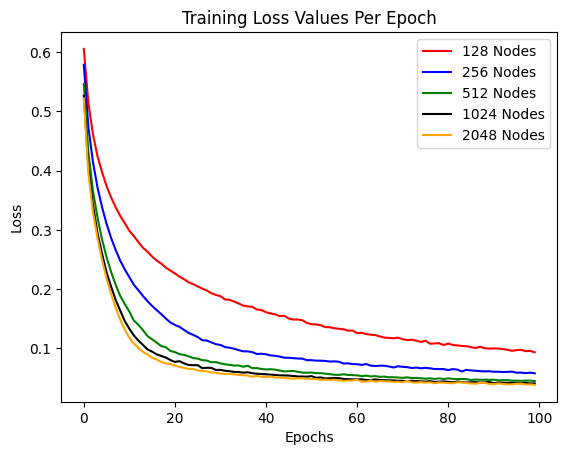

In [37]:
%matplotlib inline

plt.plot(epoch_averages_train[0],linestyle='-', color='red', label='128 Nodes')
plt.plot(epoch_averages_train[1],linestyle='-', color='blue', label='256 Nodes')
plt.plot(epoch_averages_train[2],linestyle='-', color='green', label='512 Nodes')
plt.plot(epoch_averages_train[3],linestyle='-', color='black', label='1024 Nodes')
plt.plot(epoch_averages_train[4],linestyle='-', color='orange', label='2048 Nodes')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Values Per Epoch")
plt.legend(loc="upper right")

plt.show()
print() #do not remove, prevents duplicate plot bug

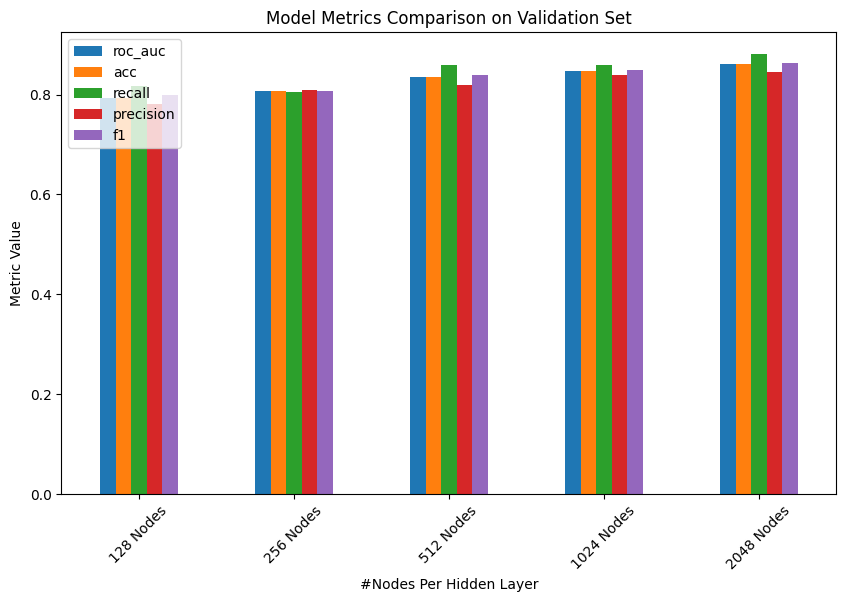

In [38]:
%matplotlib inline

df_val = pd.DataFrame({
                        'roc_auc': roc_auc,
                        'acc': acc,
                        'recall': recall,
                        'precision': precision,
                        'f1': f1
                        })

results_nodes = ["128", "256", "512", "1024", "2048"]
df_val.index = [f'{results_nodes[0]} Nodes', f'{results_nodes[1]} Nodes',
            f'{results_nodes[2]} Nodes', f'{results_nodes[3]} Nodes',
            f'{results_nodes[4]} Nodes']
df_val.plot(kind='bar', figsize=(10, 6))
plt.title("Model Metrics Comparison on Validation Set")
plt.xlabel("#Nodes Per Hidden Layer")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

print() #do not remove, prevents duplicate plot bug

## Results from the Pre-trained *Updated* Model Evaluation on Test Set
After loading the pre-trained model, we evaluated it on a designated test set to assess its generalization capability.

In [39]:
def test_fnc(_ddi_model,
         _threshold=0.47,
         metrics=metrics):

    _ddi_model.eval()
    predictions = []

    for test_batch in test_generator:
        prediction = _ddi_model(test_batch.drug_features_left, test_batch.drug_features_right)
        if isinstance(prediction, collections.abc.Sequence):
            prediction = prediction[0]
        prediction = prediction.detach().cpu().numpy()
        identifiers = test_batch.identifiers
        prediction[prediction >= _threshold] = 1
        prediction[prediction < _threshold] = 0
        identifiers["prediction"] = prediction
        predictions.append(identifiers)

    predictions_df = pd.concat(predictions)

    if metrics is None:
        metric_dict = {"roc_auc": roc_auc_score}
    else:
        metric_dict = {name: metric_resolver.lookup(name) for name in metrics}

    return {name: func(predictions_df["label"], predictions_df["prediction"]) \
            for name, func in metric_dict.items()}

In [40]:
test_results = []
results_nodes = ["128", "256", "512", "1024", "2048"]
for idx, model in enumerate(trained_models_upd):
    print(f"Testing model with {results_nodes[idx]} nodes in each layer ...")
    res = test_fnc(model)
    test_results.append(res)

Testing model with 128 nodes in each layer ...
Testing model with 256 nodes in each layer ...
Testing model with 512 nodes in each layer ...
Testing model with 1024 nodes in each layer ...
Testing model with 2048 nodes in each layer ...


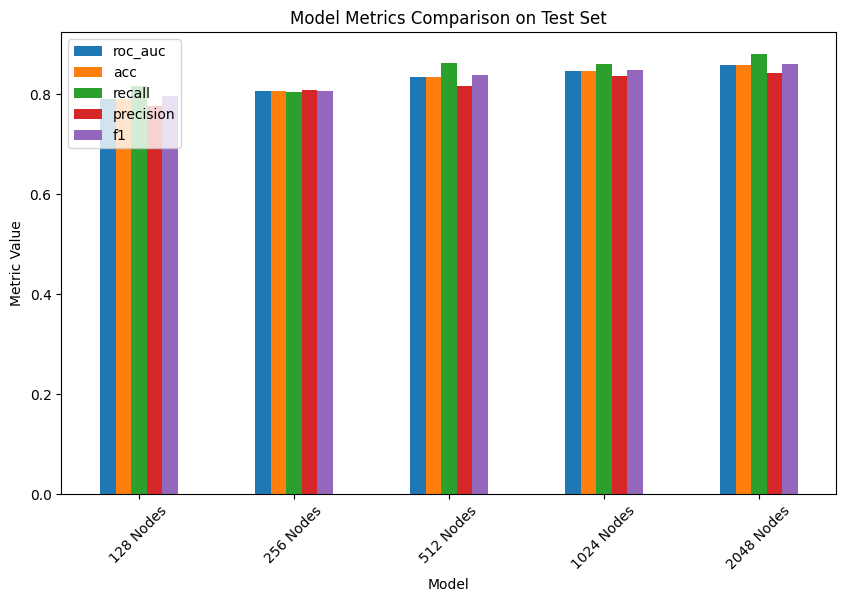

In [41]:
%matplotlib inline
df_test = pd.DataFrame([res for res in test_results])
df_test.index = [f'{results_nodes[0]} Nodes', f'{results_nodes[1]} Nodes',
            f'{results_nodes[2]} Nodes', f'{results_nodes[3]} Nodes',
            f'{results_nodes[4]} Nodes']
df_test.plot(kind='bar', figsize=(10, 6))
plt.title("Model Metrics Comparison on Test Set")
plt.xlabel("Model")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

print() #do not remove, prevents duplicate plot bug

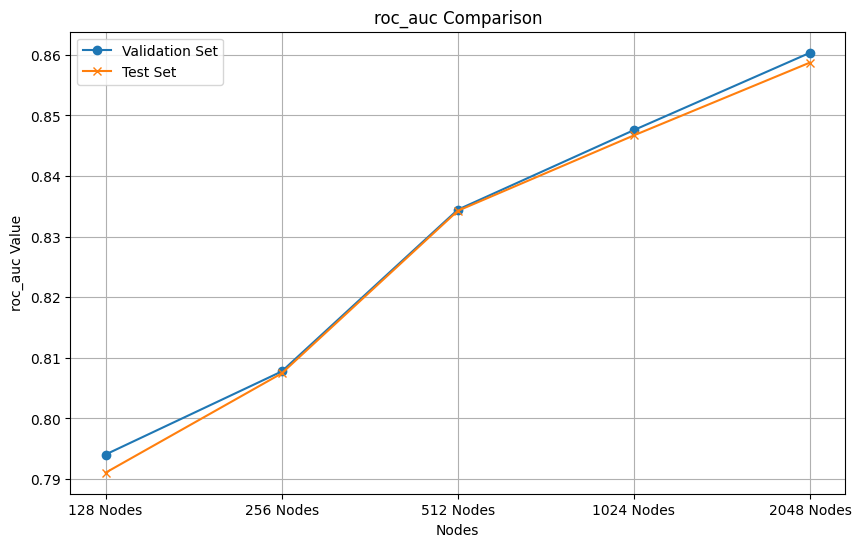

In [42]:
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.plot(df_val.index, df_val['roc_auc'], marker='o', label='Validation Set')
plt.plot(df_test.index, df_test['roc_auc'], marker='x', label='Test Set')
plt.title("roc_auc Comparison")
plt.xlabel("Nodes")
plt.ylabel("roc_auc Value")
plt.legend()
plt.grid(True)
plt.show()

print() #do not remove, prevents duplicate plot bug

Discussion
==========

This section goes into our efforts to replicate the findings of the original study using the DeepDDI model, offering insights into the reproducibility of the research, the challenges we faced, and suggestions for enhancing reproducibility in future studies.

Assessment of Reproducibility
-----------------------------

Our experiments with architectural modifications to the DeepDDI model reveal that while it is possible to approach the performance metrics reported in the original paper, discrepancies in data representation (Morgan fingerprints in ChemicalX vs. SSP/PCA in the original paper) pose challenges. These findings underscore the adaptability of DNN architectures but also highlight the need for clarity in reporting the data processing methods in software packages like ChemicalX to better support reproducibility.

### What Was Easy:

-   Model Architecture Implementation: The detailed description of the DNN architecture in the original paper, coupled with the straightforward implementation available in the ChemicalX package, greatly facilitated the setup and training process. Additionally, the availability of open-source code simplified the implementation of modifications to the model architecture.

-   Data Handling: Leveraging the DrugBank dataset via the ChemicalX package made it easy to set up and begin training models efficiently.

### What Was Difficult:

-   Resource Constraints: Conducting extensive training sessions, especially with larger models, required significant computational time.

-   Matching Reported Metrics: Initially replicating the high performance metrics reported in the original study proved challenging, particularly when using different data representations. Our modified models, however, showed that with specific architectural changes, these challenges could be mitigated.

-   Data Representation Discrepancies: The unexpected difference in data representation between the original paper and the ChemicalX package --- specifically, the use of Morgan fingerprints instead of SSP/PCA --- forced a last-minute change in our ablation study design. This discrepancy is likely responsible for the variations in our results compared to the original study.

-   Legacy Code Compatibility: The code provided in the original paper was developed for Python 2, which posed compatibility issues with modern Python environments that support Python 3. This limitation led us to rely on the ChemicalX package despite the noted issues with data representation.

### Suggestions for Improving Reproducibility

-   Detailed Computational Environment Reporting: Future studies should provide explicit details about the computational resources used, including specifics on GPU types, memory, and runtime environments, to aid in the accurate replication of results.

-   Architectural Variation Testing: We recommend that future reproductions explore a variety of architectural tweaks such as different normalization techniques and the introduction of dropout, as these were found to significantly impact model performance in our tests.

Through these experiments, we have demonstrated that even minor modifications in the neural network architecture, such as replacing batch normalization with layer normalization and adding dropout, can lead to noticeable improvements in performance. This suggests that ongoing optimization and testing of DNN parameters are crucial for advancing the field of drug-drug interaction prediction.


# References

1. Ryu JY, Kim HU, Lee SY (2018) Deep learning improves prediction of drug–drug and drug–food interactions. Proceedings of the National Academy of Sciences 115(18). doi:10.1073/pnas.1803294115.
1. AstraZeneca, ChemicalX: A PyTorch and TorchDrug based deep learning library for drug pair scoring. GitHub repository, 2022. [Online]. Available: https://github.com/AstraZeneca/chemicalx/
1. Fonseca Santiesteban, A., ChemicalX fork for Python 3.10 compatibility. GitHub repository, 2024. [Online]. Available: https://github.com/lucag2/chemicalx#egg=chemicalx
1. Wishart DS, et al. (2017) DrugBank 5.0: A major update to the DrugBank database for 2018. Nucleic Acids Res 46:D1074–D1082.
1. ChemicalX developers, "DrugBank DDI." ChemicalX Documentation, 2024. [Online]. Available: https://chemicalx.readthedocs.io/en/latest/notes/data_processing.html#drugbank-ddi